# Non-parametric Methods

In this Notebook, we are going to consider some methods of classification which are non-parametric. This means that we do not assume the data to behave like a normal distribution. The density estimation is based only on our observations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from histogram import Bin, Histogram
import scipy.stats as stats
import csv
import math

## Histogram

### 1D Implementation

One of the easiest methods to make a probability density estimation is a Histogram. The estimation is calculated by considering the number of data points nearby. In 1D, it is also very easy to implement. We show the basic implementation on a standard normal distribution. Play around with the size of the data set and the number of bins. If you want an appropriate plot, use a data-set size of about 100'000 and at least 50 bins.

In [2]:
class real_normal_distribution:
    def __init__(self, mean, var, length):
        self.mean = mean
        self.var = var
        self.std = math.sqrt(var)
        self.length = length
    def pdf(self, x):
        return stats.norm.pdf(x, loc=self.mean, scale=self.std)
    def getData(self):
        return np.random.normal(self.mean, self.std, self.length)
    
class real_gamma_distribution:
    def __init__(self, shape, scale, length):
        self.shape = shape
        self.scale = scale
        self.length = length
    def pdf(self, x):
        return stats.gamma.pdf(x, self.shape, scale=self.scale)
    def getData(self):
        return np.random.gamma(shape=self.shape, scale=self.scale, size=self.length)

Enter the number of Bins: 50
Enter the size of the training data set: 10000


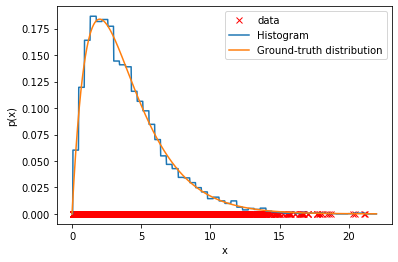

In [12]:
n_bins = int(input('Enter the number of Bins: '))
length = int(input('Enter the size of the training data set: '))

# you can also estimate any other distribution around supported by numpy
distro = real_gamma_distribution(2.0, 2.0, length)
distro = real_normal_distribution(-1.0, 2.0, length)

data = distro.getData()

data_min = np.min(data)
data_max = np.max(data)
counter = [0 for j in range(n_bins)]
vol = (data_max - data_min)/n_bins
boundaries = [data_min + j*vol for j in range(1, n_bins-1)]

def get_bin_index(x):
    if x < data_min or x > data_max:
        return None
    
    for i in range(len(boundaries)):
        if x <= boundaries[i]:
            return i
    
    # x is greater than the last boundary
    return -1

# train the histogram
for i in range(length):
    ind = get_bin_index(data[i])
    counter[ind] += 1
    
# calculate the density
def p(x):
    ind = get_bin_index(x)
    if ind is None:
        return 0
    return (counter[ind] / length) / vol
    
# visualize the density
x = np.reshape(np.linspace(math.floor(data_min), math.ceil(data_max), 1000), (1000, 1))
y = np.zeros(np.shape(x))
z = np.zeros(np.shape(x))

for i in range(1000):
    y[i] = p(x[i])
    z[i] = distro.pdf(x[i])

plt.plot(data, [0]*len(data), 'rx')

plt.plot(x, y, x, z)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(['data', 'Histogram', 'Ground-truth distribution'], loc='upper right')
plt.show()

You can compare the values of the two densities below for any point you want. To get "good" data, for the standard normal distribution you should use about 50 bins and a training data set which is large enough. Using a set of size 100'000 gives a quite accurate estimation.

In [15]:
point = float(input('Enter a data point: '))

print('p_hist = ', p(point))
print('p_true = ', distro.pdf(point))

Enter a data point: 5
p_hist =  0.10634951314657291
p_true =  0.1026062482798735


We see that the histogram is not the most accurate method of probability estimation.

A big advantage of the histogram however is that the probability estimation can be calculated without any knowledge of the original training data which can be thrown away after training: It does not have to be stored since the density is only depending on the counter and the volume of the according bin.

In case of multi-dimensional data, the computation time however grows exponentially. Even though a counter can be updated efficiently by using a Hash Table, the size of the hash table is big: If $d$ is the dimension and $B = \max_\limits{1 \leq i \leq d} N_i$ is the maximum number of bins used, its complexity is $\mathcal{O}(B^d)$.

### 2D Example

Now, we are going to consider the countour plot of a Histogram in 2D. Note that the variances do necessarily have to be greater than 0 and that the covariance matrix has to be positive semi-definite! If you choose a big number of bins, the computation takes some time. You can play around with the values below.

In [16]:
mu_x = 0
mu_y = 0
mu = np.array([mu_x, mu_y])

sigma_x = 1
assert sigma_x > 0
sigma_y = 2
assert sigma_y > 0
cov_x_y = 0.5
cov = np.array([[sigma_x, cov_x_y], [cov_x_y, sigma_y]])
assert np.linalg.det(cov) >= 0

data_size = int(1e+5)
bins_x = 100
bins_y = 100

Let us show the histogram contour. This might take some time...

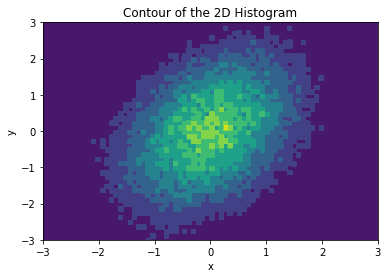

In [17]:
data = np.reshape(np.random.multivariate_normal(mu, cov, data_size), (data_size, 2))
hist = Histogram(data, [bins_x, bins_y])

# visualize the histogram
x = np.linspace(mu_x-3, mu_x+3, 500)
y = np.linspace(mu_y-3, mu_y+3, 500)

xm, ym = np.meshgrid(x, y)
n, m = np.shape(xm)
z = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        z[i, j] = hist.p(np.array([xm[i, j], ym[i, j]]))

plt.contourf(x, y, z)
plt.title('Contour of the 2D Histogram')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Classification of Data Points with Histograms

In the following example, we generate data points of a translated Gamma(2, 2)-distribution and an Exponential(1)-distribution. Using these data points, we train two histograms and use them for the classification of the test data set. Note that the plot below shows the Histogram decision boundary, not the maximum-likelihood density!

Feel free to play around with these values. You can also take any other distribution you want, but the labels in the diagram below will not change.

In [18]:
length = 5000
length_test = 100

gamma_train = np.reshape(np.random.gamma(2, 1, length), (length, 1))
gamma_train += 1
gamma_test = np.reshape(np.random.gamma(2, 1, length_test), (length_test, 1))
gamma_test += 1
exp_train = np.reshape(np.random.exponential(2, length), (length, 1))
exp_test = np.reshape(np.random.exponential(2, length_test), (length_test, 1))

Also play around with the number of bins that was used!

Enter the number of bins: 3
Classified 136 out of 200 examples correctly.
False Gamma:       58
False Exponential: 6



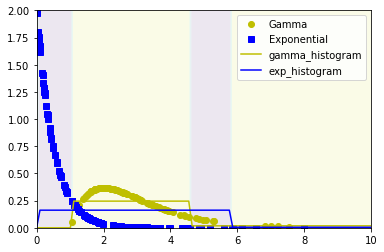

In [23]:
n_bins = int(input('Enter the number of bins: '))

hist_gamma = Histogram(gamma_train, [n_bins])
hist_exp = Histogram(exp_train, [n_bins])

# test the classification
false_gamma, false_exp, corr = 0, 0, 0
for i in range(length_test):
    if hist_gamma.p(gamma_test[i, :]) >= hist_exp.p(gamma_test[i, :]):
        corr += 1
    else:
        false_exp += 1
    
    if hist_gamma.p(exp_test[i, :]) >= hist_exp.p(exp_test[i, :]):
        false_gamma += 1
    else:
        corr += 1

print('Classified', corr, 'out of', 2*length_test, 'examples correctly.')
print('False Gamma:      ', false_gamma)
print('False Exponential:', false_exp)
print()

# get a contour for the decision boundary
def classify_with_histogram(x):
    if hist_gamma.p(x) >= hist_exp.p(x):
        return 1
    else:
        return 0

# plot the points and the decision boundary
x = np.linspace(0, 10, 100)
y = np.linspace(0, 2, 100)
xm, ym = np.meshgrid(x, y)
n, m = np.shape(xm)
z = np.zeros((n, m))

for j in range(m):
    val = classify_with_histogram(np.reshape(xm[0, j], (1, 1)))
    for i in range(n):
        z[i, j] = val
    
y_gam = []
for i in x:
    y_gam.append(hist_gamma.p([i]))
        
y_exp = []
for i in x:
    y_exp.append(hist_exp.p([i]))
    
plt.contourf(x, y, z, alpha=0.1)
plt.plot(gamma_test, stats.gamma.pdf(gamma_test, 2, 1), 'yo')
plt.plot(exp_test, 2*np.exp(-2*exp_test), 'bs')
plt.plot(x, y_gam, 'y')

plt.plot(x, y_exp, 'b')

plt.xlim((0, 10))
plt.legend(['Gamma', 'Exponential', 'gamma_histogram', 'exp_histogram'], loc='upper right')
plt.show()

## k-Nearest Neighbours

In this method, we classify a point alone by the properties of the $k$ nearest training points nearby. The implementation is rather easy, also for multi-dimensional data sets.

In [24]:
class KNN:
    data: []
    k: int
    n_classes: int

    def __init__(self, data, k, n_classes):
        self.data = data
        self.k = k
        self.n_classes = n_classes

    def classify(self, x):
        # sort the data by distance to x
        n, d = np.shape(self.data)
        points = []
        for i in range(n):
            r = 0
            for j in range(d-1):
                r += (x[j] - self.data[i, j])**2
            r = np.sqrt(r)
            # append the radius and label
            points.append((r, self.data[i, d-1]))

        dtype = [('radius', float), ('label', int)]
        points = np.array(points, dtype=dtype)
        points = np.sort(points, kind='quicksort', order='radius')

        # extract the k best labels
        counters = [0 for i in range(self.n_classes)]
        for i in range(self.k):
            counters[points[i][1]] += 1

        return np.argmax(np.array(counters))

A main difference to the Histogram is that the whole data set is now processed in a single KNN-object. Moreover, we can also process more than one class at the same time, e.g. in the following example, we handle three of them. We are going to use the following data set.

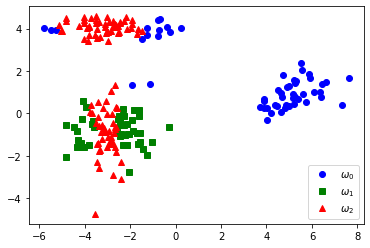

In [25]:
# load the freshly generated data
reader = csv.reader(open("knn_toy.csv", "rt", encoding="utf8"))
data = list(reader)
data = np.array(data).astype(float)

# find the appropriate classes for visualization
ind_0 = np.where(data[:, -1] == 0)[0]
ind_1 = np.where(data[:, -1] == 1)[0]
ind_2 = np.where(data[:, -1] == 2)[0]

data_0 = np.take(data, ind_0, axis=0)
data_1 = np.take(data, ind_1, axis=0)
data_2 = np.take(data, ind_2, axis=0)

# visualize
plt.plot(data_0[:, 0], data_0[:, 1], 'bo')
plt.plot(data_1[:, 0], data_1[:, 1], 'gs')
plt.plot(data_2[:, 0], data_2[:, 1], 'r^')
plt.legend(['$\omega_0$', '$\omega_1$', '$\omega_2$'], loc='lower right')
plt.show()

This Method is quite expensive since for every classification step, the whole data has to be sorted by the distance to the current point. If quicksort is used, a single classification is in the average case as expensive as $\mathcal{O}(N \log N)$, but in the worst case even as $\mathcal{O}(N^2)$. If mergesort is used, also a worst case classification is takes $\mathcal{O}(N \log N)$, but in the average case, quicksort is a bit faster.

Even though it takes some time to compute the classifications, play around with $k$. Also note that the contour might not plot the boundaries 100 % correctly.

Enter k: 50


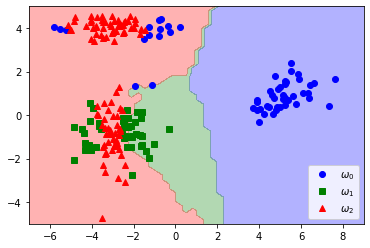

In [29]:
k = int(input('Enter k: '))

knn = KNN(data, k, 3)        

# plot the points and the decision boundary
x = np.linspace(-7, 9)
y = np.linspace(-5, 5)
xm, ym = np.meshgrid(x, y)

n, m = np.shape(xm)
z = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        z[i, j] = knn.classify(np.array([xm[i, j], ym[i, j]]))

plt.contourf(x, y, z, alpha=0.3, levels=[-0.5, 0.5, 1.5, 2.5], colors=('b', 'g', 'r'))
plt.plot(data_0[:, 0], data_0[:, 1], 'bo')
plt.plot(data_1[:, 0], data_1[:, 1], 'gs')
plt.plot(data_2[:, 0], data_2[:, 1], 'r^')
plt.legend(['$\omega_0$', '$\omega_1$', '$\omega_2$'], loc='lower right')
plt.show()

You can now test the classification on your own data points.

In [30]:
x = float(input('Enter x: '))
y = float(input('Enter y: '))

omega = knn.classify(np.array([x, y]))

print('This point is classified to omega_'+str(omega))

Enter x: 5
Enter y: 5
This point is classified to omega_0


Unlike in the histogram, we do not calculate a probability density here. This could however easily be done by adding a few lines of code to calculated the likelihood

$$p(x \mid \omega_i) = \frac{k_i}{n_i \cdot V},$$

where $k_i$ is the number of samples beloning to $\omega_i$ in $V$ and $n_i$ is the total number of samples belonging to $\omega_i$. By also taking the prior

$$p(\omega_i) = \frac{n_i}{N},$$

our classification above corresponds to Bayesian classification. 

## k-Means

K-Means clustering is a popular method to partition $n$ observations into $k$ clusters. The only thing we must know in advance is the number of clusters k. 

We are going to divide a 2D dataset into k clusters.

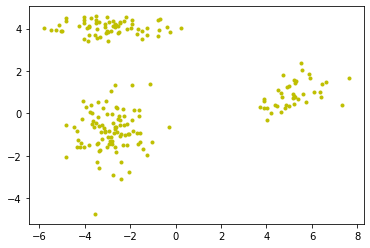

In [31]:
# load the data
colours = ['bo', 'gx', 'r*', 'cv', 'm1', 'y2', 'k3', 'w4']

reader = csv.reader(open("knn_toy.csv", "rt", encoding="utf8"))
data = list(reader)
data = np.array(data).astype(float)
data[:,2] = 0.0
# visualize
plt.plot(data[:, 0], data[:, 1], 'y.')
plt.show()

In [32]:
clusters = int(input('Enter number of clusters: '))

Enter number of clusters: 3


Now we randomly take 3 datapoints as the means of the 3 clusters.

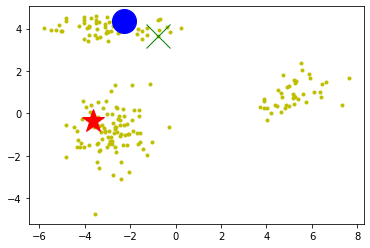

[array([-2.25981805,  4.33013041]),
 array([-0.77755452,  3.64217289]),
 array([-3.64707495, -0.35355698])]

In [36]:
means = []
for i in range(clusters):
    rnd = np.random.randint(data.shape[0])
    # Instead of a random value, try taking the K=3 first values by uncommenting the next line
#     rnd = i
    means.append(data[rnd,0:-1])
plt.plot(data[:, 0], data[:, 1], 'y.')
for (i, mean) in enumerate(means):
    plt.plot(mean[0], mean[1], colours[i], markersize=24)
plt.show()
means

No we need to initializing the $k$ random clusters. This is done by assigning each datapoint to its closest mean value.

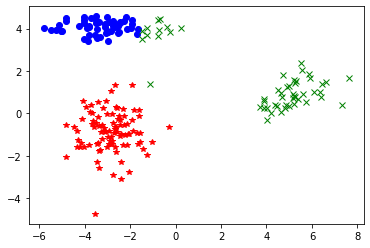

In [37]:
def assign_to_cluster(mydata, mymeans):
    for i in range(0,mydata.shape[0]):
        x = mydata[i,0:-1]
        minimumDistance = math.inf
        cluster = 0
        for (j, mean) in enumerate(mymeans):
            distance = np.linalg.norm(x-mean)
            if distance < minimumDistance:
                cluster = j
                minimumDistance = distance
        mydata[i,-1] = cluster
    return mydata
    
data = assign_to_cluster(data, means)

for i in range(clusters):
    index = np.where(data[:, -1] == i)[0]
    plt.plot(data[index, 0], data[index, 1], colours[i])

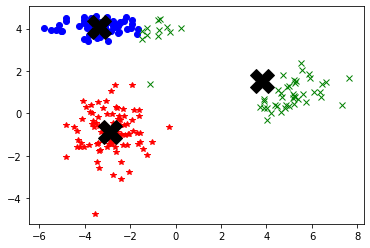

In [38]:
def update_means(mydata, mymeans):
    for i in range(clusters):
        d = np.where(mydata[:, -1] == i)[0]
        mymeans[i] = np.mean(mydata[d,0:-1], axis=0)
    return mymeans

means = update_means(data, means)

# plt.plot(data[:, 0], data[:, 1], 'y.')
for i in range(clusters):
    index = np.where(data[:, -1] == i)[0]
    plt.plot(data[index, 0], data[index, 1], colours[i])
for (i, mean) in enumerate(means):
    plt.plot(mean[0], mean[1], 'kX', markersize=24)

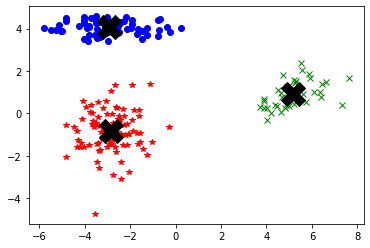

In [46]:
for i in range(1):
    data = assign_to_cluster(data, means)
    means = update_means(data, means)

for i in range(clusters):
    index = np.where(data[:, -1] == i)[0]
    plt.plot(data[index, 0], data[index, 1], colours[i])
for (i, mean) in enumerate(means):
    plt.plot(mean[0], mean[1], 'kX', markersize=24)

## K-Means relation to Gaussian Mixture Models (GMMs)
GMM is referred to as soft clustering, whereas k-means is a hard clustering method with responsible 1 or 0 for each cluster. 